# Pima Indians Diabetes Prediction
- Dataset: https://www.kaggle.com/uciml/pima-indians-diabetes-database
- Attempting to classify whether or not a patient has diabetes based on some diagnostic measurements 
- All patients in the dataset are females at least 21 years old of Pima Indian heritage 

In [ ]:
import os
os.environ['http_proxy'] = "http://web-proxy.corp.hpecorp.net:8080" 
os.environ['https_proxy'] = "http://web-proxy.corp.hpecorp.net:8080" 

In [ ]:
# Jupyter notebooks don't have TensorFlow installed.
!pip3 install tensorflow==2.3.0 --user

## After successful installation of tensorflow, restart the kernel

# Setting up environment and Data Preprocessing

In [1]:
import numpy
import os
import pandas as pd
import tensorflow as tf

## Set the project repo 
def ProjectRepo(path):
    ProjectRepo = os.popen('bdvcli --get cluster.project_repo').read().rstrip()
    print(ProjectRepo)
    return ProjectRepo + '/' + path        

## Load the dataset
dataset = pd.read_csv(ProjectRepo('data/Pima_Indians/pima-indians-diabetes.csv'), delimiter=",")
dataset.columns = [
    "NumTimesPrg", "PlGlcConc", "BloodP",
    "SkinThick", "TwoHourSerIns", "BMI",
    "DiPedFunc", "Age", "HasDiabetes"]

/bd-fs-mnt/project_repo


- Pregnancies
- Glucose — The blood plasma glucose concentration after a 2 hour oral glucose tolerance test.
- BloodPressure — Diastolic blood pressure (mm/HG).
- SkinThickness — Skinfold thickness of the triceps (mm).
- Insulin — 2 hour serum insulin (mu U/ml).
- BMI — Body mass index (kg/m squared)
- DiabetesPedigreeFunction — A function that determines the risk of type 2 diabetes based on family history, the larger the function, the higher the risk of type 2 diabetes.
- Age.
- Outcome — Whether the person is diagnosed with type 2 diabetes (1 = yes, 0 = no).

In [2]:
corr = dataset.corr()
corr

,NumTimesPrg,PlGlcConc,BloodP,SkinThick,TwoHourSerIns,BMI,DiPedFunc,Age,HasDiabetes
NumTimesPrg,1.000000,0.128846,0.141197,-0.082495,-0.072999,0.017518,-0.033927,0.544018,0.221087
PlGlcConc,0.128846,1.000000,0.152498,0.056381,0.332383,0.220955,0.136903,0.262408,0.465856
BloodP,0.141197,0.152498,1.000000,0.207308,0.089098,0.281777,0.041180,0.239571,0.064882
SkinThick,-0.082495,0.056381,0.207308,1.000000,0.437974,0.392553,0.183498,-0.115873,0.073265
TwoHourSerIns,-0.072999,0.332383,0.089098,0.437974,1.000000,0.198111,0.185579,-0.040942,0.131984
BMI,0.017518,0.220955,0.281777,0.392553,0.198111,1.000000,0.140546,0.035911,0.292695
DiPedFunc,-0.033927,0.136903,0.041180,0.183498,0.185579,0.140546,1.000000,0.032738,0.173245
Age,0.544018,0.262408,0.239571,-0.115873,-0.040942,0.035911,0.032738,1.000000,0.236417
HasDiabetes,0.221087,0.465856,0.064882,0.073265,0.131984,0.292695,0.173245,0.236417,1.000000


## Visualizing correlation of variables with a heatmap

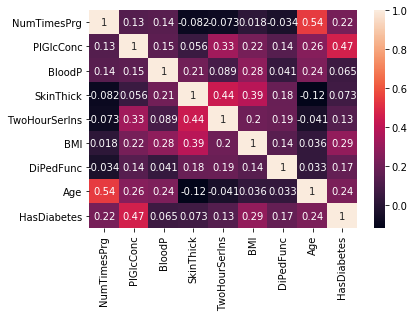

In [3]:
%matplotlib inline
import seaborn as sns
sns.heatmap(corr, annot = True)

## Plotting histogram distribution of each feature variable

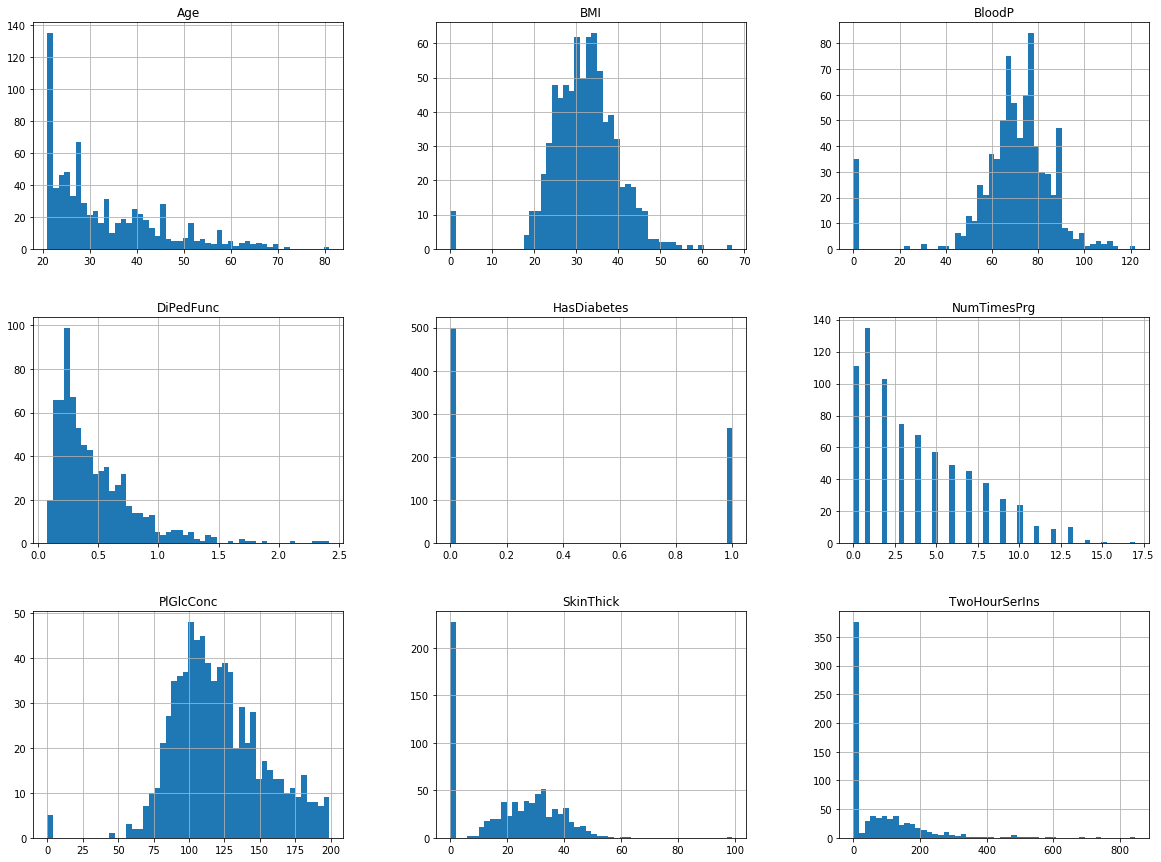

In [4]:
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(20, 15))
plt.show()

# Model Development (Part 1)
- Attempting first model with XGB

In [5]:
# First XGBoost model for Pima Indians dataset
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

# load data
dataset = loadtxt(ProjectRepo('data/Pima_Indians/pima-indians-diabetes.csv'), delimiter=",") 

# split data into X and y
X_train = dataset[:,0:8]
y_train = dataset[:,8]

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

#
print(model.get_xgb_params())

/bd-fs-mnt/project_repo
{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': None, 'validate_parameters': False, 'verbosity': None}


In [6]:
%attachments

  Cluster ID  Training Cluster    ML Engine
------------  ------------------  -----------
           1  pythoncpu           python


# Model Development (Part 2)
- Second model using keras with remote training cluster
- Save model and prepare for TensorFlow Serving

In [7]:
%%train 1

import numpy
import os
import pandas as pd
import tensorflow as tf
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

## Set the project repo 
def ProjectRepo(path):
    ProjectRepo = os.popen('bdvcli --get cluster.project_repo').read().rstrip()
    print(ProjectRepo)
    return ProjectRepo + '/' + path        

## Load the dataset
print("Loading data")
dataset = loadtxt(ProjectRepo('data/Pima_Indians/pima-indians-diabetes.csv'), delimiter=",") 
dataset.shape

# Split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]

# Define the keras model
print("Building model")
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the keras model on the dataset
print("Training model")
model.fit(X, y, epochs=150, batch_size=10, verbose= 0)

# Evaluate the keras model
_, accuracy = model.evaluate(X, y, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

# Make class predictions with the model
predictions = model.predict_classes(X)

# Summarize the first 3 cases
for i in range(3):
	print('%s => %d (expected %d)' % (X[i].tolist(), predictions[i], y[i]))

# Save model weights and architecture together
print("Saving model")
model.save(ProjectRepo('models/Diabetes_Prediction/db_remote.h5'))

# Evaluate the keras model
_, accuracy = model.evaluate(X, y, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

# Make class predictions with the model
predictions = model.predict_classes(X)

# Summarize the first 5 cases
for i in range(5):
	print('%s => %d (expected %d)' % (X[i].tolist(), predictions[i], y[i]))
    
# Prepare TF Serving
print("Preparing for TF Serving")
MODEL_VERSION = 1
tf.keras.backend.set_learning_phase(0) 
model = tf.keras.models.load_model(ProjectRepo('models/Diabetes_Prediction/db_remote.h5'))
export_path = ProjectRepo('models/Diabetes_Prediction/' + str(MODEL_VERSION))
tf.keras.models.save_model(model, export_path)
    
# Summarize model.
model.summary()
print("Done")

History URL: http://bluedata-2.bdlocal:10001/history/3


## After executing the cell above, a historyl url will be returned. Copy and paste the url into the cell below. You can execute the cell below as many times as you'd like to see the job status in real time. 

In [9]:
%logs --url  http://bluedata-2.bdlocal:10001/history/3

Job Status: Finished
Loading data
/bd-fs-mnt/project_repo
Building model
Training model
Accuracy: 76.95
[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0] => 1 (expected 1)
[1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351, 31.0] => 0 (expected 0)
[8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672, 32.0] => 1 (expected 1)
Saving model
/bd-fs-mnt/project_repo
Accuracy: 76.95
[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0] => 1 (expected 1)
[1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351, 31.0] => 0 (expected 0)
[8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672, 32.0] => 1 (expected 1)
[1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167, 21.0] => 0 (expected 0)
[0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288, 33.0] => 1 (expected 1)
Preparing for TF Serving
/bd-fs-mnt/project_repo
/bd-fs-mnt/project_repo
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
________________

Clearing session notes:
https://stackoverflow.com/questions/50895110/what-do-i-need-k-clear-session-and-del-model-for-keras-with-tensorflow-gpu